<a href="https://colab.research.google.com/github/RidhimaSinare/STC_Hate_Semantic_Analysis/blob/main/STC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Utils** **functions**

In [12]:
import re
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


def process_tweet(tweet):

    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean


def build_freqs(tweets, ys):

    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1

            else:
                freqs[pair] = 1

    return freqs

In [13]:
import nltk
from os import getcwd


In [14]:
import numpy as np
import pandas as pd
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [15]:
from nltk.corpus import twitter_samples
twitter_samples.fileids()
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')


In [16]:
# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

In [17]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [18]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


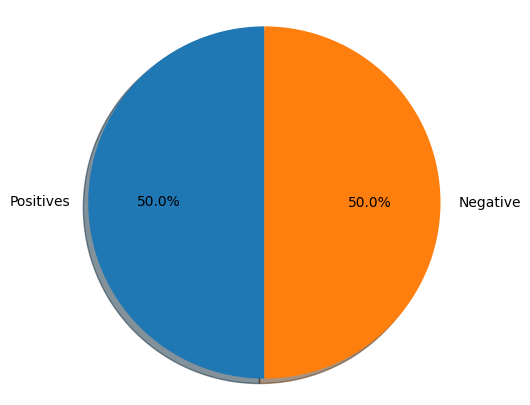

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 5))


labels = 'Positives', 'Negative'

sizes = [len(all_positive_tweets), len(all_negative_tweets)]

plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.axis('equal')
plt.show()

In [20]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11337


In [21]:
# test the function below
print('Example of a positive tweet: \n', train_x[0])
print('Processed version of the tweet: \n', process_tweet(train_x[0]))

Example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


# 1. Logistic Regression

In [22]:
def sigmoid(z):
    h = 1 / (1 + np.exp(-z))

    return h

In [23]:
#graient descent function
def gradientDescent(x,y,theta,alpha,num_iters):
  #x-> matrix of features, y-> labels of matrix, theta->weight vector of dimension, alpha->learning rate, num_iters->number of iterations

  #** here cost J should go down

  m=x.shape[0]

  for i in range(0,num_iters):

    z=np.dot(x,theta)

    h=sigmoid(z)

    J = -1./m * (np.dot(y.transpose(), np.log(h)) + np.dot((1-y).transpose(),np.log(1-h)))

    theta = theta - (alpha/m) * np.dot(x.transpose(),(h-y))

  J=float(J)

  return J,theta


#2. Extract Features
* Positive score
* negative score

In [24]:
def extract_features(tweet,freqs):

  words=process_tweet(tweet)
  x=np.zeros((1,3))
  x[0][0]=1

  for word in words:

    x[0][1]+=freqs.get((word,1.0),0)
    x[0][2]+= freqs.get((word,0.0),0)


  assert(x.shape==(1,3))
  return x

#3. Training Model

In [25]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.24215478.
The resulting vector of weights is [7e-08, 0.00052391, -0.00055517]


In [26]:
def predict_tweet(tweet, freqs, theta):

    # extract the features of the tweet and store it into x
    x = extract_features(tweet,freqs)

    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x,theta))

    return y_pred

#Checking accuracy of logistic regression

In [27]:
def test_logistic_regression(test_x, test_y, freqs, theta):


    y_hat = []

    for tweet in test_x:

        y_pred = predict_tweet(tweet, freqs, theta)

        if y_pred > 0.5:
            y_hat.append(1)
        else:
            y_hat.append(0)
    accuracy = (y_hat==np.squeeze(test_y)).sum()/len(test_x)

    return accuracy

In [28]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9950


In [ ]:
tweets = [
    "I love the sunshine today! ☀️",
    "Just had the best meal of my life at that new restaurant.",
    "Watching my favorite movie, feeling so happy right now!",
    "Had a great time with friends this weekend. #goodvibes",
    "I'm so grateful for all the wonderful people in my life.",
    "Stuck in traffic again. This is so frustrating!",
    "Feeling really down today. Can't shake off this feeling.",
    "The service at this restaurant is terrible. Never coming back.",
    "Lost my wallet today. What a disaster!",
    "Dealing with a bad cold. Can't seem to get better. 😞"
]

In [ ]:
for tweet in tweets:
  #print(process_tweet(tweet))
  pred=predict_tweet(tweet,freqs,theta)
  print(pred)
  if pred > 0.5:
      print('Positive sentiment')
  else:
      print('Negative sentiment')


[[0.52554649]]
Positive sentiment
[[0.51317712]]
Positive sentiment
[[0.50105655]]
Positive sentiment
[[0.51736089]]
Positive sentiment
[[0.4823774]]
Negative sentiment
[[0.49829542]]
Negative sentiment
[[0.44949441]]
Negative sentiment
[[0.49210953]]
Negative sentiment
[[0.4962588]]
Negative sentiment
[[0.47205037]]
Negative sentiment


#NAIVE BAYES MODEL

In [29]:
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from os import getcwd

In [30]:
def test_lookup(func):
    freqs = {('sad', 0): 4,
             ('happy', 1): 12,
             ('oppressed', 0): 7}
    word = 'happy'
    label = 1
    if func(freqs, word, label) == 12:
        return 'SUCCESS!!'
    return 'Failed Sanity Check!'


def lookup(freqs, word, label):
    n = 0

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [31]:
# get the sets of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

# avoid assumptions about the length of all_positive_tweets
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

#Process data

In [32]:
def count_tweets(result, tweets, ys):

    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            # define the key, which is the word and label tuple
            pair = (word,y)

            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1

            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1

    return result

In [33]:
# Testing your function


result = {}
tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]
count_tweets(result, tweets, ys)

{('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}

In [34]:

freqs = count_tweets({}, train_x, train_y)

In [35]:
def train_naive_bayes(freqs, train_x, train_y):

    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos, N_neg, V_pos, V_neg
    N_pos = N_neg = V_pos = V_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
            # increment the count of unique positive words by 1
            V_pos += 1

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:
            # increment the count of unique negative words by 1
            V_neg += 1

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents
    D_pos = (len(list(filter(lambda x: x > 0, train_y))))

    # Calculate D_neg, the number of negative documents
    D_neg = (len(list(filter(lambda x: x <= 0, train_y))))

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word,1)
        freq_neg = lookup(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [36]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
9085


#Testing the Naive Bayes model

In [37]:
def naive_bayes_predict(tweet, logprior, loglikelihood):

    # process the tweet to get a list of words
    word_l = process_tweet(tweet)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]


    return p

In [38]:
my_tweet = 'She smiled.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1.5737244858565678


In [39]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):

    accuracy = 0

    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats-test_y))

    # Accuracy is 1 minus the error
    accuracy = 1-error

    return accuracy

In [40]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(test_x, test_y, logprior, loglikelihood)))

Naive Bayes accuracy = 0.9940


In [41]:
tweets = [
    "I love the sunshine today! ☀️",
    "Just had the best meal of my life at that new restaurant.",
    "Watching my favorite movie, feeling so happy right now!",
    "Had a great time with friends this weekend. #goodvibes",
    "I'm so grateful for all the wonderful people in my life.",
    "Stuck in traffic again. This is so frustrating!",
    "Feeling really down today. Can't shake off this feeling.",
    "The service at this restaurant is terrible. Never coming back.",
    "Lost my wallet today. What a disaster!",
    "Dealing with a bad cold. Can't seem to get better. 😞"
]


for tweet in tweets:
  #print(process_tweet(tweet))
  pred=naive_bayes_predict(tweet,logprior,loglikelihood)
  print(pred)
  if pred > 1:
      print('Positive sentiment')
  else:
      print('Negative sentiment')

1.5710810195704323
Positive sentiment
1.1446614128336128
Positive sentiment
1.190924856196888
Positive sentiment
3.247635731765257
Positive sentiment
1.3893957694991366
Positive sentiment
-3.098189605382207
Negative sentiment
-4.277403214149615
Negative sentiment
-0.18665298246942796
Negative sentiment
-3.2908168932551605
Negative sentiment
-7.157709399522696
Negative sentiment
